# 1. Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

print(os.getcwd())


c:\Users\hp\Desktop\10 Acadamy\VS code\portfolio-forecasting-gmf\notebooks


# 2. Settings

In [2]:
tickers = ["TSLA", "BND", "SPY"]

all_forecasts = []
all_metrics = []
RESULTS_DIR = "./results"  # Set your desired output folder here
os.makedirs(RESULTS_DIR, exist_ok=True)

 # 3. Main loop: Load, preprocess, train ARIMA, forecast


=== Processing TSLA ===


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\st

Best (p,d,q): (2, 0, 1) | AIC=1159.67
MAE: 0.2424, RMSE: 0.3103


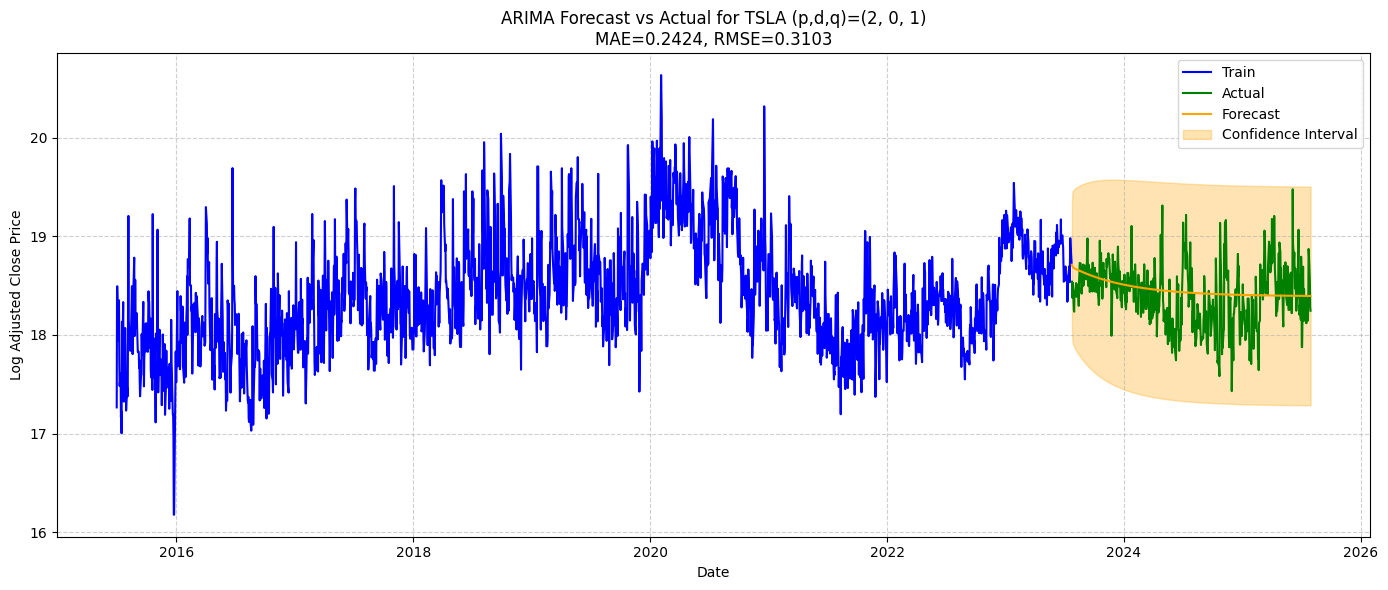


=== Processing BND ===


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\st

Best (p,d,q): (1, 1, 2) | AIC=1036.83
MAE: 0.2815, RMSE: 0.3934


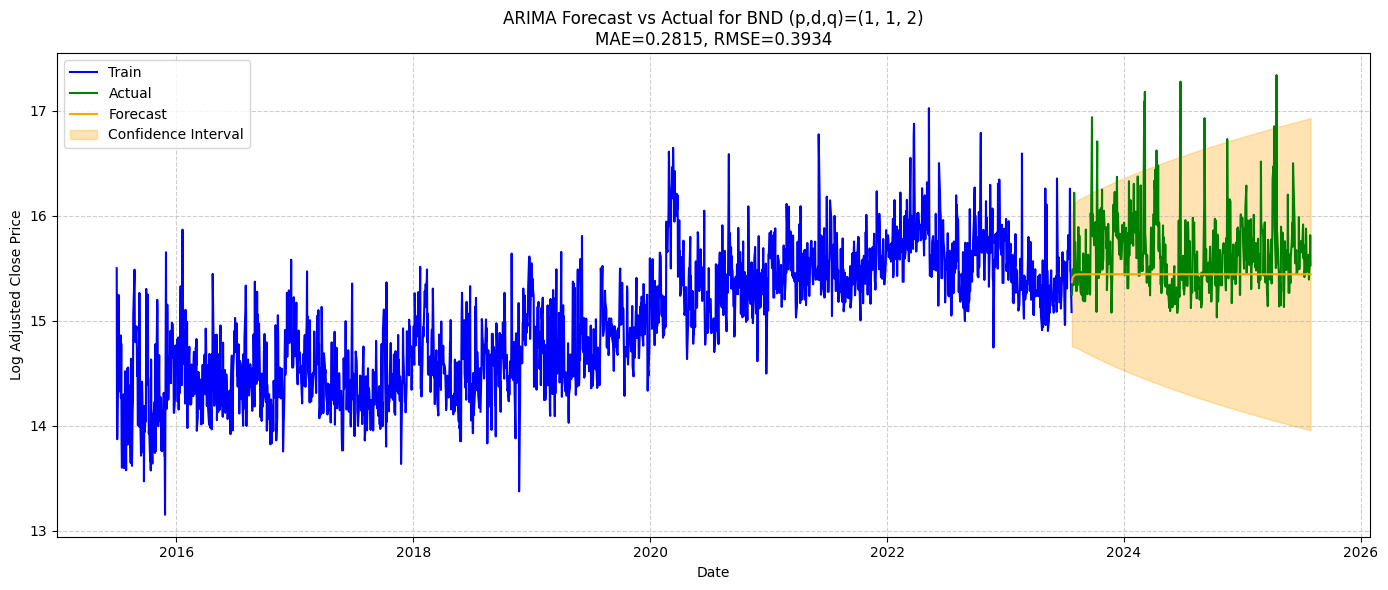


=== Processing SPY ===


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\st

Best (p,d,q): (3, 1, 3) | AIC=579.72
MAE: 0.2905, RMSE: 0.3705


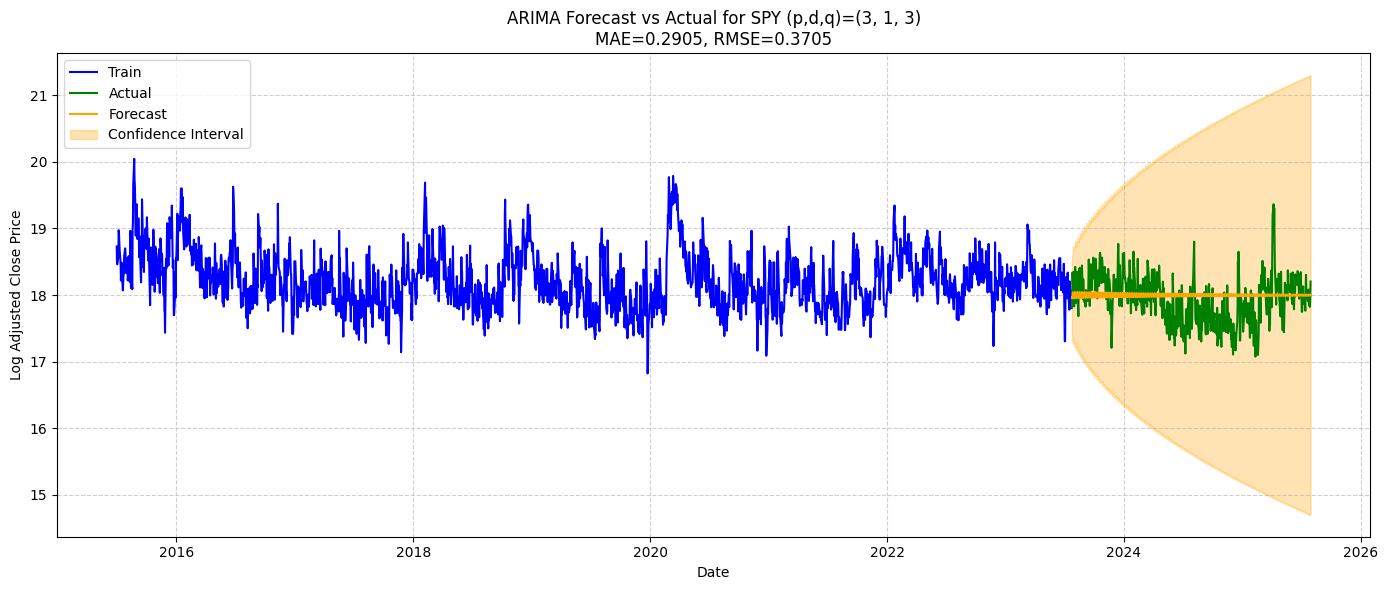

In [3]:
for ticker in tickers:
    print(f"\n=== Processing {ticker} ===")
    
    # 1. Load processed CSV
    df = pd.read_csv(f"../data/processed/{ticker}_processed.csv", index_col=0, parse_dates=True)

    # 2. Train-test split
    train_size = int(len(df) * 0.8)
    train, test = df['log_adjclose'][:train_size], df['log_adjclose'][train_size:]

    # 3. Parameter grid
    p = range(0, 4)
    d = range(0, 2)
    q = range(0, 4)
    pdq = list(itertools.product(p, d, q))
    
    best_aic = np.inf
    best_params = None
    best_model = None

    # 4. Grid search for best ARIMA model
    for param in pdq:
        try:
            model = sm.tsa.ARIMA(train, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_model = results
        except:
            continue

    print(f"Best (p,d,q): {best_params} | AIC={best_aic:.2f}")

    # 5. Forecast
    forecast_res = best_model.get_forecast(steps=len(test))
    forecast_df = forecast_res.summary_frame()
    
    # Add ticker to forecast dataframe
    forecast_df['ticker'] = ticker
    forecast_df['date'] = test.index
    
    all_forecasts.append(forecast_df)

    # 6. Metrics
    mae = mean_absolute_error(test, forecast_df['mean'])
    rmse = mean_squared_error(test, forecast_df['mean']) ** 0.5
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    all_metrics.append({
        'TICKER': ticker,
        'p': best_params[0],
        'd': best_params[1],
        'q': best_params[2],
        'AIC': best_aic,
        'MAE': mae,
        'RMSE': rmse
    })
    
    # 7. Plot
    plt.figure(figsize=(14, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Actual', color='green')
    plt.plot(test.index, forecast_df['mean'], label='Forecast', color='orange')
    plt.fill_between(test.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], 
                     color='orange', alpha=0.3, label='Confidence Interval')
    plt.title(f"ARIMA Forecast vs Actual for {ticker} (p,d,q)={best_params}\nMAE={mae:.4f}, RMSE={rmse:.4f}")
    plt.xlabel("Date")
    plt.ylabel("Log Adjusted Close Price")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# 4.Combine all forecasts into one DataFrame

In [4]:
combined_forecasts = pd.concat(all_forecasts)
combined_forecasts.to_csv(os.path.join(RESULTS_DIR, "forecasts_arima_all.csv"), index=False)

metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv(os.path.join(RESULTS_DIR, "metrics_arima_all.csv"), index=False)

print("\nAll tickers processed.")
print(metrics_df)


All tickers processed.
  TICKER  p  d  q          AIC       MAE      RMSE
0   TSLA  2  0  1  1159.667807  0.242409  0.310280
1    BND  1  1  2  1036.828130  0.281504  0.393408
2    SPY  3  1  3   579.719829  0.290512  0.370503
